# Convert pivot data to format

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# import pandas as pd
# df = pd.read_csv("/content/drive/MyDrive/RESEARCH/RawPvotData.csv")
# list1 = ["Exports", "Imports", "Losses", "Transformation", "Total energy supply", "Final consumption" , "Primary production"] # add new row names here from pivot table
# commoditieslist = ["Biofuels and waste", "Oil", "Electricity and heat", "Nuclear", "Natural Gas", "Coal"] # add new column names here from pivot table
# df = df[df.rowName.isin(list1) == True]
# df = df[df.colName_Dashboard.isin(commoditieslist) == True]
# df_ = df.groupby(["Region Name", "Sub-region Name", "Year"], as_index=False)
# data = []
# for eachgroup in df_.__iter__():
#   tempdf = pd.DataFrame(eachgroup[1])
#   tempobj = {}
#   for item in tempdf.iterrows():
#     tempobj["Region"]= item[1]["Region Name"]
#     tempobj["Sub-region"]= item[1]["Sub-region Name"]
#     tempobj["Year"]= item[1]["Year"]
#     tempobj[item[1]["colName_Dashboard"] + " " + item[1]['rowName']] = item[1]["Terajoules"] # format = column name + rowname
#   data.append(tempobj)
# output  = pd.DataFrame(data)
# output = output.fillna(0)
# output.to_csv("/content/drive/MyDrive/RESEARCH/AutomatedEnergyoutput.csv")

#1. Import

In [ ]:
import tensorflow as tf
import pandas as pd
!pip install yahoo_fin
from yahoo_fin import stock_info as si
!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib as mpl
import math
from statsmodels.tsa.seasonal import seasonal_decompose


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 3.8 MB/s 
     |████████████████████████████████| 83 kB 1.6 MB/s 
     |████████████████████████████████| 127 kB 61.8 MB/s 
     |████████████████████████████████| 112 kB 65.3 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=23cf15dd8c7c5708c801424aab2faf62b7523166fbfb9cfa00d5c4feb74e7493
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=5d8151f75145ceb1bcb96821797516883eb2cf5d30767c8cb04dc699d90e6594
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=88d5bf0a6b32a36500919f48eb20833b80d6d2044be118b75b24c

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#2. Collect

In [ ]:
df = {}
df = si.get_data('NG=F')
df = pd.DataFrame(df)
df = df [['open', 'close', 'high', 'low']].round(3)
resampled_df = df.resample('1D').mean()
resampled_df.interpolate(method='linear', axis = 0, inplace= True, limit_direction='forward')
# plt.plot(resampled_df['volume'])
plt.show()

#3. Preliminary Analysis

In [ ]:
resampled_df.corr()

,open,close,high,low
open,1.000000,0.997653,0.998693,0.998890
close,0.997653,1.000000,0.998850,0.998906
high,0.998693,0.998850,1.000000,0.998248
low,0.998890,0.998906,0.998248,1.000000


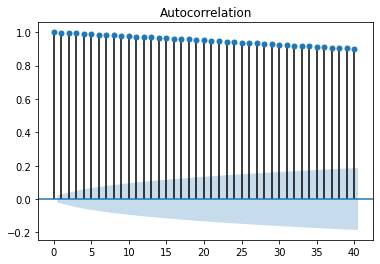

In [ ]:
stripped_resampled_df = resampled_df['close']
plot_acf(stripped_resampled_df)
plt.show()

In [ ]:
ma_resampled_df = pd.DataFrame(resampled_df['close'])
ma_resampled_df['ma180'] = resampled_df['close'].rolling(180).mean()
ma_resampled_df['ma60'] = resampled_df['close'].rolling(60).mean()
ma_resampled_df['ma30'] = resampled_df['close'].rolling(30).mean()
# ma_resampled_df['volume'] = resampled_df['volume']
ma_resampled_df = ma_resampled_df[199:]
ma_resampled_df

,close,ma180,ma60,ma30
2001-03-17,5.041667,6.428162,5.859711,5.204456
2001-03-18,5.053333,6.426403,5.828783,5.187300
2001-03-19,5.065000,6.424986,5.794267,5.173017
2001-03-20,5.280000,6.424947,5.757600,5.168383
2001-03-21,5.050000,6.424497,5.717228,5.158567
...,...,...,...,...
2022-07-31,8.265000,6.534317,7.338808,7.179383
2022-08-01,8.283000,6.549772,7.335442,7.266208
2022-08-02,7.706000,6.565428,7.321825,7.335525
2022-08-03,8.266000,6.585950,7.313103,7.425233


#4. Sentiment Analyser

In [ ]:
!pip install textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from textblob import TextBlob
plt.style.use('fivethirtyeight')

## a. KEYWORD

In [ ]:
keyword = {"keyw": "Natural Gas","asset": 'commodity'}

if keyword['asset'] == 'stocks':
  keyword['scrape_search'] = keyword['keyw'] + ' shares'
else:
  keyword['scrape_search'] = keyword['keyw'] + ' prices'

## b. Scrapper

In [ ]:
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen
import datetime
import pandas as pd

def webCrawl (search):
    news_df = pd.DataFrame(columns={"Headline", "Date_time", "URL"})
    date = datetime.datetime.now()
    date = date.date() - datetime.timedelta(days=1500)
    date = str(date)
    date = date.replace("-", "")
    date = int(date)
    search = search.replace(" ", "%20")
    search = search.replace("Limited", "")
    search = search.replace("ltd", "")
    search = search.replace("INC", "")
    search = search.replace("inc", "")
    search = search.replace("LLC", "")
    newsUrl = "https://news.google.com/rss/?q=" + str(search)
    website = urlopen(newsUrl)
    xml_page = website.read()
    website.close()
    ret_n = pd.DataFrame(columns=[""])
    soup_page = soup(xml_page, "xml")
    news_list = soup_page.findAll("item")
    # Print news title, url and publish date
    for news in news_list:
        day = (news.pubDate.text[5:7])
        wkday = str(news.pubDate.text[0:4])
        pub_time = str(news.pubDate.text[17:25])
        d = {"Jan" : "01", "Feb" : "02", "Mar" : "03", "Apr" : "04", "May" : "05", "Jun" : "06", "Jul" : "07", "Aug" : "08", "Sep" : "09", "Oct" : "10", "Nov" : "11", "Dec" : "12"}
        month = (d.get(news.pubDate.text[8:11]))
        year = (news.pubDate.text[12:16])
        date_t = str(year + "-" + month + "-" + day + " " +pub_time)
        format = "%Y-%m-%d %H:%M:%S"
        date_time = datetime.datetime.strptime(date_t, format) + datetime.timedelta(minutes = 330)
        date_time = wkday + str(date_time)
        date_a = int(str(year + month + day))

        if (date_a >= date):
            headl = news.title.text
            newslink = news.link.text
            news_df = news_df.append({"Headline": headl, "Date_time" : date_time, "URL": newslink}, ignore_index=True)
    return news_df 

print(webCrawl ('Amazon'))


                                             Headline  \
0   Amazon CSO Steve Schmidt preaches fungible res...   
1   How Will Amazon Approach U.S. Primary Care? - ...   
2   Amazon Introduces Layaway Plans on Select Item...   
3   Amazon is bucking the online ad trend and just...   
4   Amazon launches same-day delivery from some br...   
..                                                ...   
95  Leaked documents reveal Amazon managers’ proce...   
96  Amazon bets on influencers to drive sales for ...   
97  Amazon plans to start delivering packages by d...   
98  Microsoft Asks Google, Oracle to Help Crimp Am...   
99  Amazon Prime Day Shows Just How Hard Inflation...   

                  Date_time                                                URL  
0   Wed,2022-08-04 03:23:53  https://www.techtarget.com/searchsecurity/news...  
1   Wed,2022-08-03 18:46:31  https://hbr.org/2022/08/how-will-amazon-approa...  
2   Wed,2022-08-04 05:13:58  https://www.billboard.com/culture/product-r

#5. Data Augment

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

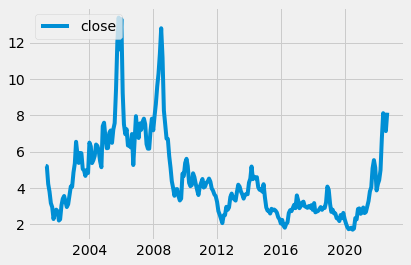

In [ ]:
monthly_resampled_df = ma_resampled_df.resample('1M').mean()
plt.plot(monthly_resampled_df['close'] ,label = 'close')
# plt.plot(monthly_resampled_df['ma30'] ,label = 'ma30')
# plt.plot(monthly_resampled_df['ma60'] ,label = 'ma60')
# plt.plot(monthly_resampled_df['ma180'] ,label = 'ma180')
# plt.plot(monthly_resampled_df['volume'] ,label = 'volume')
plt.legend(loc="upper left")
plt.show()

In [ ]:
def root(x):
  return math.sqrt(x)

In [ ]:
rows, attributes = monthly_resampled_df.shape

months = 36  

scaler_mod = scaler.fit(monthly_resampled_df)
scaler_mean = list(map(np.float32, scaler.mean_))
scaler_var = scaler.scale_
print(list(map(np.float32, scaler_mean)))
print(list(map(np.float32, scaler_var)))
monthly_resampled_df_scaled = scaler.transform (monthly_resampled_df)

train_monthly_resampled_df = monthly_resampled_df_scaled[0:(rows-months)+6]
test_monthly_resampled_df = monthly_resampled_df_scaled[(rows-months):]

print(train_monthly_resampled_df.shape, test_monthly_resampled_df.shape) 


[4.522887, 4.5137963, 4.5139875, 4.514954]
[2.222597, 2.088305, 2.182039, 2.2027333]
(228, 4) (36, 4)


In [ ]:
for rowIndex, row in enumerate(monthly_resampled_df):
  print(row)
  break

close


In [ ]:
def batch_gen(df):
  batch_size = 24
  validation_size = 1
  df = np.array(df)
  shape = df.shape
  test = []
  train = []
  for rowIndex in range(0, shape[0]):
    if rowIndex + batch_size + validation_size == shape[0]:
      train.append(df[rowIndex: rowIndex + batch_size])
      test.append(df[rowIndex+batch_size][1])
      break

    else:
      train.append(df[rowIndex: rowIndex + batch_size])
      test.append(df[rowIndex+batch_size][1])
   

  test = np.array(test).reshape((len(test),1))
  train = np.array(train)
  return test , train

batch_Y_monthly_df_train, batch_X_monthly_df_train = batch_gen(train_monthly_resampled_df)


print(f'Shape of Training Data: {batch_X_monthly_df_train.shape}')
print(f'Shape of Testing Data: {batch_Y_monthly_df_train.shape}')

Shape of Training Data: (204, 24, 4)
Shape of Testing Data: (204, 1)


#6. LSTM


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import LeakyReLU
from tensorflow import keras

## a. Model Compilation

In [ ]:
model = Sequential()
model.add(LSTM(120, activation='relu', input_shape=(batch_X_monthly_df_train.shape[1], batch_X_monthly_df_train.shape[2]), return_sequences=True))
model.add(LSTM(50, activation=keras.layers.LeakyReLU(alpha=0.01), return_sequences=True))
model.add(LSTM(50, activation=keras.layers.LeakyReLU(alpha=0.01), return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(batch_Y_monthly_df_train.shape[1]))
model.compile(loss='mse', optimizer= keras.optimizers.Adam(lr=0.01))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 24, 120)           60000     
                                                                 
 lstm_16 (LSTM)              (None, 24, 50)            34200     
                                                                 
 lstm_17 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 114,451
Trainable params: 114,451
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## b. Model Fitting

In [ ]:
history = model.fit(batch_X_monthly_df_train, batch_Y_monthly_df_train, epochs=20, batch_size = 12, validation_split=0.1 , verbose = 1)

Epoch 1/20
16/16 [==============================] - 5s 77ms/step - loss: 1.1503 - val_loss: 0.6147
Epoch 2/20
16/16 [==============================] - 1s 50ms/step - loss: 1.1501 - val_loss: 0.1202
Epoch 3/20
16/16 [==============================] - 1s 48ms/step - loss: 0.9755 - val_loss: 0.0102
Epoch 4/20
16/16 [==============================] - 1s 47ms/step - loss: 0.5109 - val_loss: 0.0047
Epoch 5/20
16/16 [==============================] - 1s 45ms/step - loss: 0.2545 - val_loss: 0.1615
Epoch 6/20
16/16 [==============================] - 1s 48ms/step - loss: 0.2088 - val_loss: 0.0980
Epoch 7/20
16/16 [==============================] - 1s 47ms/step - loss: 0.1313 - val_loss: 0.0027
Epoch 8/20
16/16 [==============================] - 1s 51ms/step - loss: 0.0733 - val_loss: 0.0112
Epoch 9/20
16/16 [==============================] - 1s 49ms/step - loss: 0.0836 - val_loss: 0.0165
Epoch 10/20
16/16 [==============================] - 1s 46ms/step - loss: 0.0550 - val_loss: 0.0062
Epoch 11/

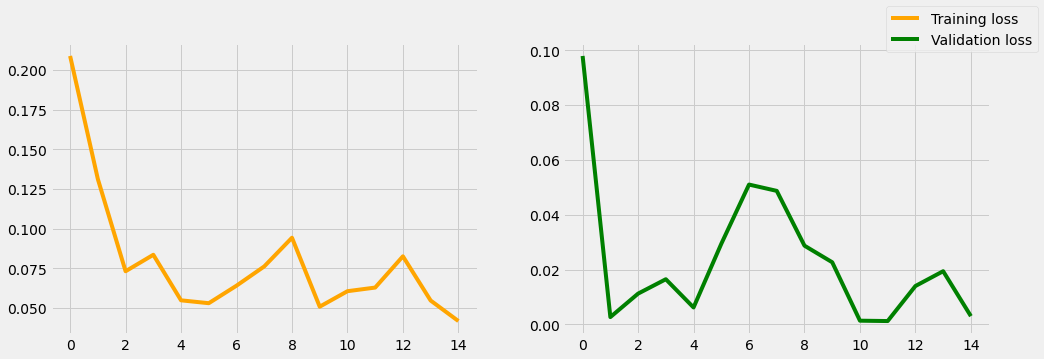

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,5])
ax1.plot(history.history['loss'][5:], label='Training loss', c='orange')
ax2.plot(history.history['val_loss'][5:], label='Validation loss' , c = 'green')
fig.legend()
fig.show()

In [ ]:
batch_Y_monthly_df_test , batch_X_monthly_df_test = batch_gen(test_monthly_resampled_df)
print(f'Shape of Testing Data: {batch_X_monthly_df_test.shape}')
print(f'Shape of Validating Data: {batch_Y_monthly_df_test.shape}')



Shape of Testing Data: (12, 24, 4)
Shape of Validating Data: (12, 1)


In [ ]:
pred_data = batch_X_monthly_df_test[0]

result = []

for i in range(0, 36):
  res = model.predict(np.array([pred_data]))[0,0]
  res = (res * scaler_var[0]) + scaler_mean[0]
  result.append(res)
  pred_data = scaler.inverse_transform(pred_data)
  res_30 = res
  res_60 = sum([*pred_data[-2:,2] , res])/4
  res_180 = sum([*pred_data[-5:,2] , res])/8
  pred_data = list(pred_data)
  pred_data.append(np.array([res, res_30, res_60, res_180]))
  pred_data.pop(0)
  pred_data = np.array(pred_data)
  pred_data = scaler.transform(pred_data)

print(result)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid 

[3.476127597528933, 3.4302820435296724, 3.224992951149196, 2.965142040429325, 2.711149796834792, 2.4665941617938087, 2.2089108413304674, 1.9415063515098234, 1.669056338983507, 1.4034283670298757, 1.1541724445972719, 0.9292038132605125, 0.7335001674517496, 0.5698048428898588, 0.43855395417724097, 0.3384860543989294, 0.26703691687081577, 0.2206879499040202, 0.19497944451456473, 0.1849625862773827, 0.18620575135300133, 0.19481305328108434, 0.2075138974978108, 0.221775851822283, 0.23592281602680298, 0.24925372131552948, 0.2610002005274854, 0.27089200038536365, 0.2788756001420891, 0.285100963871149, 0.2898282765904998, 0.2933065952419769, 0.2958024637441783, 0.2974753845215572, 0.29852672276112546, 0.29913982676474493]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


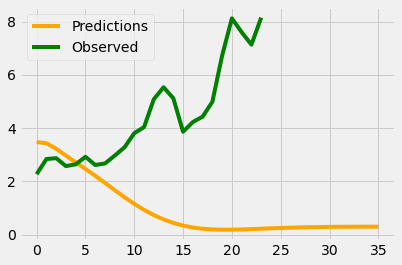

In [ ]:
test_monthly_resampled_df_unscaled = scaler.inverse_transform(test_monthly_resampled_df)

plt.plot(result[:], label='Predictions', c='orange')
plt.plot(test_monthly_resampled_df_unscaled[12:, 0], label='Observed' , c = 'green')
plt.legend()
plt.show()

In [ ]:
model.save('/content/model.h5')

#7. Research

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
import pandas as pd
supp_df = pd.DataFrame(pd.read_excel('/content/drive/MyDrive/RESEARCH/2019_Energy_Reports_Ungrouped_Collated.xlsx'))

In [ ]:
supply = ['Coal Supply', 'Oil Supply','Natural Gas Supply', 'Bio Supply ', 'Nuke Supply','Electric & Thermal Supply']
transformation = ['Coal Transformation', 'Oil Transformation','Natural Gas Transformation', 'Bio Transformation ', 'Nuke Transformation','Electric & Thermal Transformation']
consumption = ['Coal Consumption', 'Oil Consumption','Natural Gas Consumption', 'Bio Consumption ', 'Nuke Consumption','Electric & Thermal Consumption']
imports = ['Coal Import', 'Oil Import','Natural Gas Import', 'Bio Import ', 'Nuke Import','Electric & Thermal Import']
exports = ['Coal Export', 'Oil Export','Natural Gas Export', 'Bio Export ', 'Nuke Export','Electric & Thermal Export']
indice = ['Year', 'Continent', 'Region']

In [ ]:
import matplotlib.pyplot as plt

